# Домашнее задание № 8

In [1]:
%%capture
!pip install datasets

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [3]:
import re
import pandas as pd
import numpy as np
from datasets import load_dataset
from string import punctuation
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## Задание 1 (4 балла)

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [4]:
data = pd.read_csv("lenta_40k.csv.zip")

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {"PAD": 0, "UNK": 1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

MEAN_LEN = np.median([len(x) for x in X])

MAX_LEN = int(MEAN_LEN + 30)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

### Модель 1

In [7]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.LSTM(128, return_sequences=True)(lstm_1)
last_state = lstm_2[:, -1, :]

avg_pool = keras.layers.GlobalAveragePooling1D()(lstm_2)
max_pool = keras.layers.GlobalMaxPooling1D()(lstm_2)

concatenated = keras.layers.concatenate([last_state, avg_pool, max_pool])

outputs = keras.layers.Dense(len(label2id), activation="softmax")(concatenated)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")])

In [8]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=15)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - loss: 2.6108 - rec@prec: 0.0000e+00 - val_loss: 2.3079 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - loss: 2.1961 - rec@prec: 2.8359e-05 - val_loss: 1.8314 - val_rec@prec: 0.0374
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 535ms/step - loss: 1.7682 - rec@prec: 0.0192 - val_loss: 1.5727 - val_rec@prec: 0.1610
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - loss: 1.4310 - rec@prec: 0.2043 - val_loss: 1.3969 - val_rec@prec: 0.2570
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 559ms/step - loss: 1.1959 - rec@prec: 0.3714 - val_loss: 1.2785 - val_rec@prec: 0.3616
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 552ms/step - loss: 0.9732 - rec@prec: 0.5723 - val_loss: 1.1505 - val_rec@prec: 0.4757
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 519ms/step - loss: 0.8028 - rec@prec: 0.7210 - val_loss: 1.1202 - val_rec@prec: 0.5559
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - loss: 0.6742 - rec@prec: 0.807

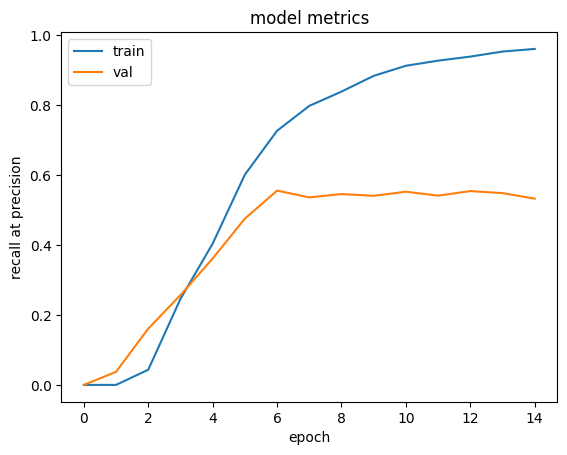

In [9]:
plt.plot(model.history.history["rec@prec"])
plt.plot(model.history.history["val_rec@prec"])
plt.title("model metrics")
plt.ylabel("recall at precision")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [10]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step


In [11]:
print(classification_report(y_valid.argmax(1), pred, labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

      Путешествия       0.00      0.00      0.00        21
           Бизнес       0.12      0.09      0.10        22
           Россия       0.62      0.72      0.66       481
         Культура       0.73      0.75      0.74       159
             Крым       0.00      0.00      0.00         2
              Дом       0.64      0.70      0.67        66
            Спорт       0.91      0.92      0.92       195
    Культпросвет        0.00      0.00      0.00         1
              Мир       0.78      0.64      0.70       410
        Экономика       0.70      0.73      0.71       239
      Бывший СССР       0.69      0.66      0.68       159
         Из жизни       0.26      0.21      0.23        84
         Ценности       0.64      0.30      0.41        23
   69-я параллель       0.00      0.00      0.00         4
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       0.19      0.13      0.16       

### Модель 2

In [12]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(lstm_1)
last_state = lstm_2[:, -1, :]

avg_pool = keras.layers.GlobalAveragePooling1D()(lstm_2)
max_pool = keras.layers.GlobalMaxPooling1D()(lstm_2)

concatenated = keras.layers.concatenate([last_state, avg_pool, max_pool])

outputs = keras.layers.Dense(len(label2id), activation="softmax")(concatenated)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")])

In [13]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=15)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 2.5700 - rec@prec: 5.6242e-06 - val_loss: 1.9757 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 1.8725 - rec@prec: 0.0236 - val_loss: 1.6132 - val_rec@prec: 0.1821
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 1.4839 - rec@prec: 0.2011 - val_loss: 1.3052 - val_rec@prec: 0.2998
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 1.1348 - rec@prec: 0.4294 - val_loss: 1.1773 - val_rec@prec: 0.4225
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.9274 - rec@prec: 0.6369 - val_loss: 1.1633 - val_rec@prec: 0.4653
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.7850 - rec@prec: 0.7324 - val_loss: 1.2192 - val_rec@prec: 0.4549
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 0.7013 - rec@prec: 0.7845 - val_loss: 1.2715 - val_rec@prec: 0.4558
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.6007 - rec@prec: 0.8373 - val_loss: 1.3234 - val_r

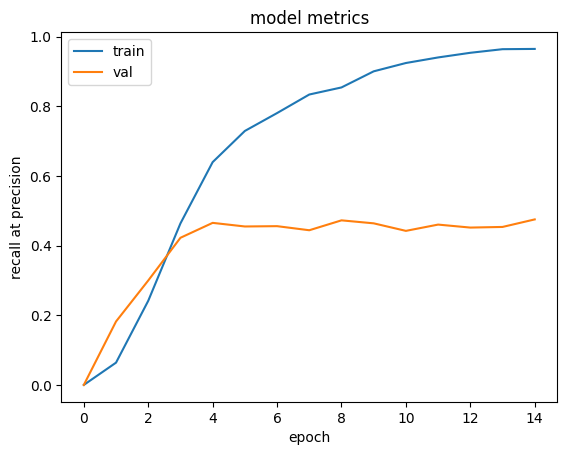

In [14]:
plt.plot(model.history.history["rec@prec"])
plt.plot(model.history.history["val_rec@prec"])
plt.title("model metrics")
plt.ylabel("recall at precision")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [15]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 566ms/step


In [16]:
print(classification_report(y_valid.argmax(1), pred, labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

      Путешествия       0.31      0.24      0.27        21
           Бизнес       0.12      0.05      0.07        22
           Россия       0.64      0.69      0.66       481
         Культура       0.69      0.71      0.70       159
             Крым       0.00      0.00      0.00         2
              Дом       0.60      0.61      0.60        66
            Спорт       0.92      0.94      0.93       195
    Культпросвет        0.00      0.00      0.00         1
              Мир       0.69      0.71      0.70       410
        Экономика       0.74      0.74      0.74       239
      Бывший СССР       0.63      0.58      0.60       159
         Из жизни       0.26      0.37      0.31        84
         Ценности       0.48      0.57      0.52        23
   69-я параллель       0.00      0.00      0.00         4
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       0.21      0.12      0.15       

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:

1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM

2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать

3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [17]:
dataset = load_dataset("tner/wikiann", "ru")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

wikiann.py:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

### Препроцессинг

In [18]:
vocab = Counter()

for sent in dataset["train"]["tokens"]:
    vocab.update([x.lower() for x in sent])

word2id = {"PAD": 0, "UNK": 1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for sent in dataset["train"]["tokens"]:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

X_test = []

for sent in dataset["test"]["tokens"]:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

MAX_LEN = max(len(x) for x in X)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding="post")

label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()}

y = keras.preprocessing.sequence.pad_sequences(dataset["train"]["tags"], value=7,
                                                  maxlen=MAX_LEN, padding="post")
y_test = keras.preprocessing.sequence.pad_sequences(dataset["test"]["tags"], value=7,
                                                       maxlen=MAX_LEN, padding="post")

### Инференс

In [19]:
def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall("\w+|[^\w\s]+", text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding="post"))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

### Модель 1

In [20]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru_layer = keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_layer = keras.layers.LSTM(128, return_sequences=True)(gru_layer)

outputs = keras.layers.Dense(len(label2id), activation="softmax")(lstm_layer)

model_1 = keras.Model(inputs=inputs, outputs=outputs)
model_1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [21]:
model_1.fit(X, y,
            validation_data=(X_test, y_test),
            batch_size=128,
            epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.8547 - loss: 0.6007 - val_accuracy: 0.9417 - val_loss: 0.1913
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.9464 - loss: 0.1635 - val_accuracy: 0.9662 - val_loss: 0.1016
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.9754 - loss: 0.0740 - val_accuracy: 0.9725 - val_loss: 0.0826
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9856 - loss: 0.0421 - val_accuracy: 0.9705 - val_loss: 0.0916
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.9936 - loss: 0.0233 - val_accuracy: 0.9719 - val_loss: 0.0912


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


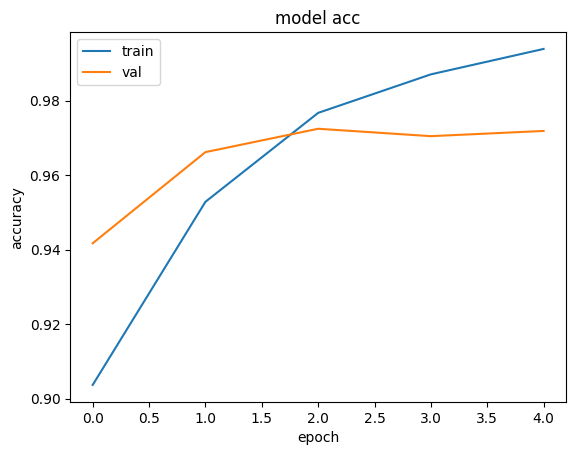

In [22]:
print(model_1.history.history.keys())
plt.plot(model_1.history.history["accuracy"])
plt.plot(model_1.history.history["val_accuracy"])
plt.title("model acc")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [23]:
pred = model_1.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step


In [24]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.78      0.46      0.58      4560
       B-ORG       0.35      0.73      0.47      4074
       B-PER       0.61      0.30      0.40      3542
       I-LOC       0.82      0.55      0.65      3060
       I-ORG       0.72      0.75      0.74      8008
       I-PER       0.92      0.60      0.73      7544
           O       0.88      0.93      0.90     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.76      0.66      0.69    540000
weighted avg       0.98      0.97      0.97    540000



In [25]:
label_seq(
    "Между тем телекомпания НТВ взорвалась у здания госбанка Пакистана рядом с домом правительства на Краснопресненской",
    word2id, id2labels, MAX_LEN, model_1
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[('Между', 'O'),
 ('тем', 'O'),
 ('телекомпания', 'O'),
 ('НТВ', 'O'),
 ('взорвалась', 'O'),
 ('у', 'O'),
 ('здания', 'O'),
 ('госбанка', 'B-ORG'),
 ('Пакистана', 'I-ORG'),
 ('рядом', 'O'),
 ('с', 'O'),
 ('домом', 'O'),
 ('правительства', 'O'),
 ('на', 'O'),
 ('Краснопресненской', 'B-ORG')]

In [26]:
label_seq(
    "Акакий Акакиевич Башмачкин не обнаружил здания ИКО ГКУ ЦЗН ЦАО на улице Лесной",
    word2id, id2labels, MAX_LEN, model_1
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[('Акакий', 'B-ORG'),
 ('Акакиевич', 'I-ORG'),
 ('Башмачкин', 'I-ORG'),
 ('не', 'O'),
 ('обнаружил', 'O'),
 ('здания', 'O'),
 ('ИКО', 'O'),
 ('ГКУ', 'O'),
 ('ЦЗН', 'O'),
 ('ЦАО', 'O'),
 ('на', 'O'),
 ('улице', 'B-ORG'),
 ('Лесной', 'I-ORG')]

In [27]:
label_seq(
    "Веритас Рацио, называющий себя доктором Рацио, окончил Высшую академию истины и вступил в Гильдию эрудитов",
    word2id, id2labels, MAX_LEN, model_1
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[('Веритас', 'B-ORG'),
 ('Рацио', 'I-ORG'),
 (',', 'O'),
 ('называющий', 'O'),
 ('себя', 'O'),
 ('доктором', 'B-PER'),
 ('Рацио', 'I-PER'),
 (',', 'O'),
 ('окончил', 'O'),
 ('Высшую', 'B-ORG'),
 ('академию', 'I-ORG'),
 ('истины', 'I-ORG'),
 ('и', 'O'),
 ('вступил', 'O'),
 ('в', 'O'),
 ('Гильдию', 'O'),
 ('эрудитов', 'O')]

### Модель 2

In [28]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.LSTM(100, return_sequences=True)(embeddings)
add_1 = keras.layers.add([embeddings, lstm_1])
lstm_2 = keras.layers.LSTM(100, return_sequences=True)(add_1)
add_2 = keras.layers.add([embeddings, lstm_2])
lstm_3 = keras.layers.LSTM(100, return_sequences=True)(add_2)

outputs = keras.layers.Dense(len(label2id), activation="softmax")(lstm_3)

model_2 = keras.Model(inputs=inputs, outputs=outputs)
model_2.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [29]:
model_2.fit(X, y,
            validation_data=(X_test, y_test),
            batch_size=128,
            epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.8560 - loss: 0.5731 - val_accuracy: 0.9393 - val_loss: 0.2020
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - accuracy: 0.9448 - loss: 0.1781 - val_accuracy: 0.9637 - val_loss: 0.1093
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 279ms/step - accuracy: 0.9710 - loss: 0.0839 - val_accuracy: 0.9719 - val_loss: 0.0844
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.9830 - loss: 0.0474 - val_accuracy: 0.9690 - val_loss: 0.0847
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 291ms/step - accuracy: 0.9909 - loss: 0.0286 - val_accuracy: 0.9707 - val_loss: 0.0878


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


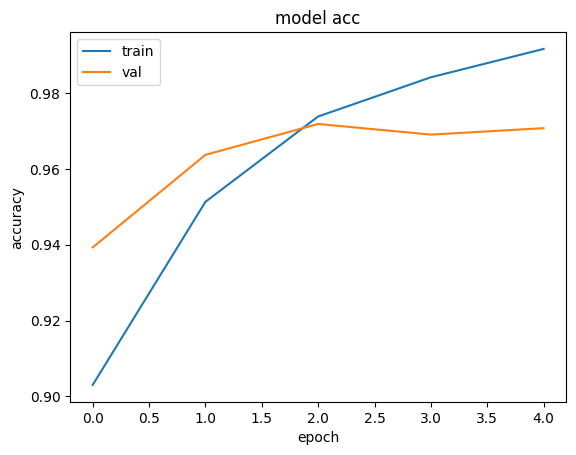

In [30]:
print(model_2.history.history.keys())
plt.plot(model_2.history.history["accuracy"])
plt.plot(model_2.history.history["val_accuracy"])
plt.title("model acc")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [31]:
pred = model_2.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step


In [32]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.49      0.65      0.56      4560
       B-ORG       0.59      0.40      0.48      4074
       B-PER       0.55      0.30      0.39      3542
       I-LOC       0.79      0.61      0.68      3060
       I-ORG       0.65      0.80      0.72      8008
       I-PER       0.89      0.60      0.72      7544
           O       0.86      0.91      0.89     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.73      0.66      0.68    540000
weighted avg       0.97      0.97      0.97    540000



In [33]:
label_seq(
    "Между тем телекомпания НТВ взорвалась у здания госбанка Пакистана рядом с домом правительства на Краснопресненской",
    word2id, id2labels, MAX_LEN, model_2
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[('Между', 'O'),
 ('тем', 'O'),
 ('телекомпания', 'B-ORG'),
 ('НТВ', 'I-ORG'),
 ('взорвалась', 'I-ORG'),
 ('у', 'O'),
 ('здания', 'O'),
 ('госбанка', 'B-ORG'),
 ('Пакистана', 'I-ORG'),
 ('рядом', 'O'),
 ('с', 'O'),
 ('домом', 'O'),
 ('правительства', 'O'),
 ('на', 'O'),
 ('Краснопресненской', 'O')]

In [34]:
label_seq(
    "Акакий Акакиевич Башмачкин не обнаружил здания ИКО ГКУ ЦЗН ЦАО на улице Лесной",
    word2id, id2labels, MAX_LEN, model_2
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[('Акакий', 'O'),
 ('Акакиевич', 'I-ORG'),
 ('Башмачкин', 'I-ORG'),
 ('не', 'O'),
 ('обнаружил', 'O'),
 ('здания', 'O'),
 ('ИКО', 'O'),
 ('ГКУ', 'I-ORG'),
 ('ЦЗН', 'I-ORG'),
 ('ЦАО', 'I-ORG'),
 ('на', 'O'),
 ('улице', 'B-ORG'),
 ('Лесной', 'I-ORG')]

In [35]:
label_seq(
    "Веритас Рацио, называющий себя доктором Рацио, окончил Высшую академию истины и вступил в Гильдию эрудитов",
    word2id, id2labels, MAX_LEN, model_2
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[('Веритас', 'O'),
 ('Рацио', 'I-ORG'),
 (',', 'O'),
 ('называющий', 'B-LOC'),
 ('себя', 'O'),
 ('доктором', 'B-PER'),
 ('Рацио', 'O'),
 (',', 'O'),
 ('окончил', 'O'),
 ('Высшую', 'B-ORG'),
 ('академию', 'I-ORG'),
 ('истины', 'I-ORG'),
 ('и', 'O'),
 ('вступил', 'O'),
 ('в', 'O'),
 ('Гильдию', 'O'),
 ('эрудитов', 'O')]

### Модель 3

In [36]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
conv_1 = keras.layers.Conv1D(kernel_size=5, filters=256, padding="same", strides=1)(lstm_1)
lstm_2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(conv_1)
conv_2 = keras.layers.Conv1D(kernel_size=5, filters=256, padding="same", strides=1)(lstm_2)

outputs = keras.layers.Dense(len(label2id), activation="softmax")(conv_2)

model_3 = keras.Model(inputs=inputs, outputs=outputs)
model_3.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [37]:
model_3.fit(X, y,
            validation_data=(X_test, y_test),
            batch_size=128,
            epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 384ms/step - accuracy: 0.8931 - loss: 0.3532 - val_accuracy: 0.9603 - val_loss: 0.1170
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 383ms/step - accuracy: 0.9699 - loss: 0.0893 - val_accuracy: 0.9781 - val_loss: 0.0671
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy: 0.9889 - loss: 0.0328 - val_accuracy: 0.9836 - val_loss: 0.0554
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 382ms/step - accuracy: 0.9966 - loss: 0.0112 - val_accuracy: 0.9838 - val_loss: 0.0638
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 62s 393ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9830 - val_loss: 0.0715


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


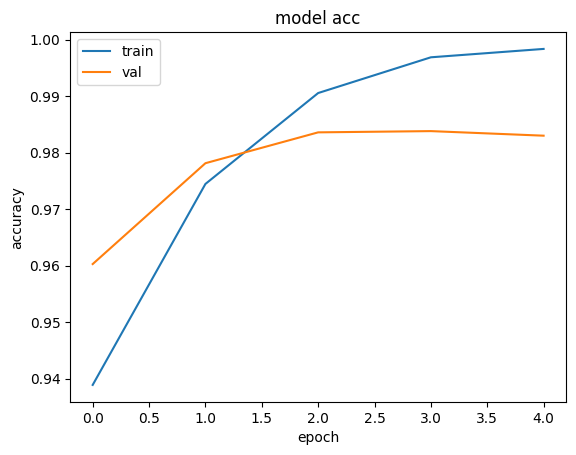

In [38]:
print(model_3.history.history.keys())
plt.plot(model_3.history.history["accuracy"])
plt.plot(model_3.history.history["val_accuracy"])
plt.title("model acc")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [39]:
pred = model_3.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step


In [40]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.76      0.77      0.77      4560
       B-ORG       0.49      0.82      0.62      4074
       B-PER       0.90      0.84      0.87      3542
       I-LOC       0.80      0.77      0.79      3060
       I-ORG       0.79      0.78      0.78      8008
       I-PER       0.94      0.88      0.91      7544
           O       0.96      0.91      0.94     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.83      0.85      0.83    540000
weighted avg       0.99      0.98      0.98    540000



In [41]:
label_seq(
    "Между тем телекомпания НТВ взорвалась у здания госбанка Пакистана рядом с домом правительства на Краснопресненской",
    word2id, id2labels, MAX_LEN, model_3
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[('Между', 'O'),
 ('тем', 'O'),
 ('телекомпания', 'O'),
 ('НТВ', 'O'),
 ('взорвалась', 'I-ORG'),
 ('у', 'O'),
 ('здания', 'O'),
 ('госбанка', 'B-ORG'),
 ('Пакистана', 'I-ORG'),
 ('рядом', 'O'),
 ('с', 'O'),
 ('домом', 'B-ORG'),
 ('правительства', 'O'),
 ('на', 'O'),
 ('Краснопресненской', 'B-ORG')]

In [42]:
label_seq(
    "Акакий Акакиевич Башмачкин не обнаружил здания ИКО ГКУ ЦЗН ЦАО на улице Лесной",
    word2id, id2labels, MAX_LEN, model_3
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[('Акакий', 'O'),
 ('Акакиевич', 'O'),
 ('Башмачкин', 'O'),
 ('не', 'O'),
 ('обнаружил', 'O'),
 ('здания', 'O'),
 ('ИКО', 'O'),
 ('ГКУ', 'B-ORG'),
 ('ЦЗН', 'I-ORG'),
 ('ЦАО', 'I-ORG'),
 ('на', 'O'),
 ('улице', 'B-ORG'),
 ('Лесной', 'I-ORG')]

In [43]:
label_seq(
    "Веритас Рацио, называющий себя доктором Рацио, окончил Высшую академию истины и вступил в Гильдию эрудитов",
    word2id, id2labels, MAX_LEN, model_3
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[('Веритас', 'B-PER'),
 ('Рацио', 'I-PER'),
 (',', 'O'),
 ('называющий', 'O'),
 ('себя', 'O'),
 ('доктором', 'B-PER'),
 ('Рацио', 'O'),
 (',', 'O'),
 ('окончил', 'O'),
 ('Высшую', 'B-ORG'),
 ('академию', 'I-ORG'),
 ('истины', 'I-ORG'),
 ('и', 'O'),
 ('вступил', 'O'),
 ('в', 'O'),
 ('Гильдию', 'B-ORG'),
 ('эрудитов', 'I-ORG')]

### Результат

Третья модель оказалась лучше всего; тем не менее, все три модели ошибаются на сложных примерах.

В табличках с метриками синим подчеркнуты лучшие показатели среди всех трех моделей.

В результатах sequence labelling красным отмечены ошибки определения O как сущности или сущности как О; фиолетовым отмечены случаи, когда модель верно определила слово как сущность, но неверно определила ее тип (PER/ORG/LOC).

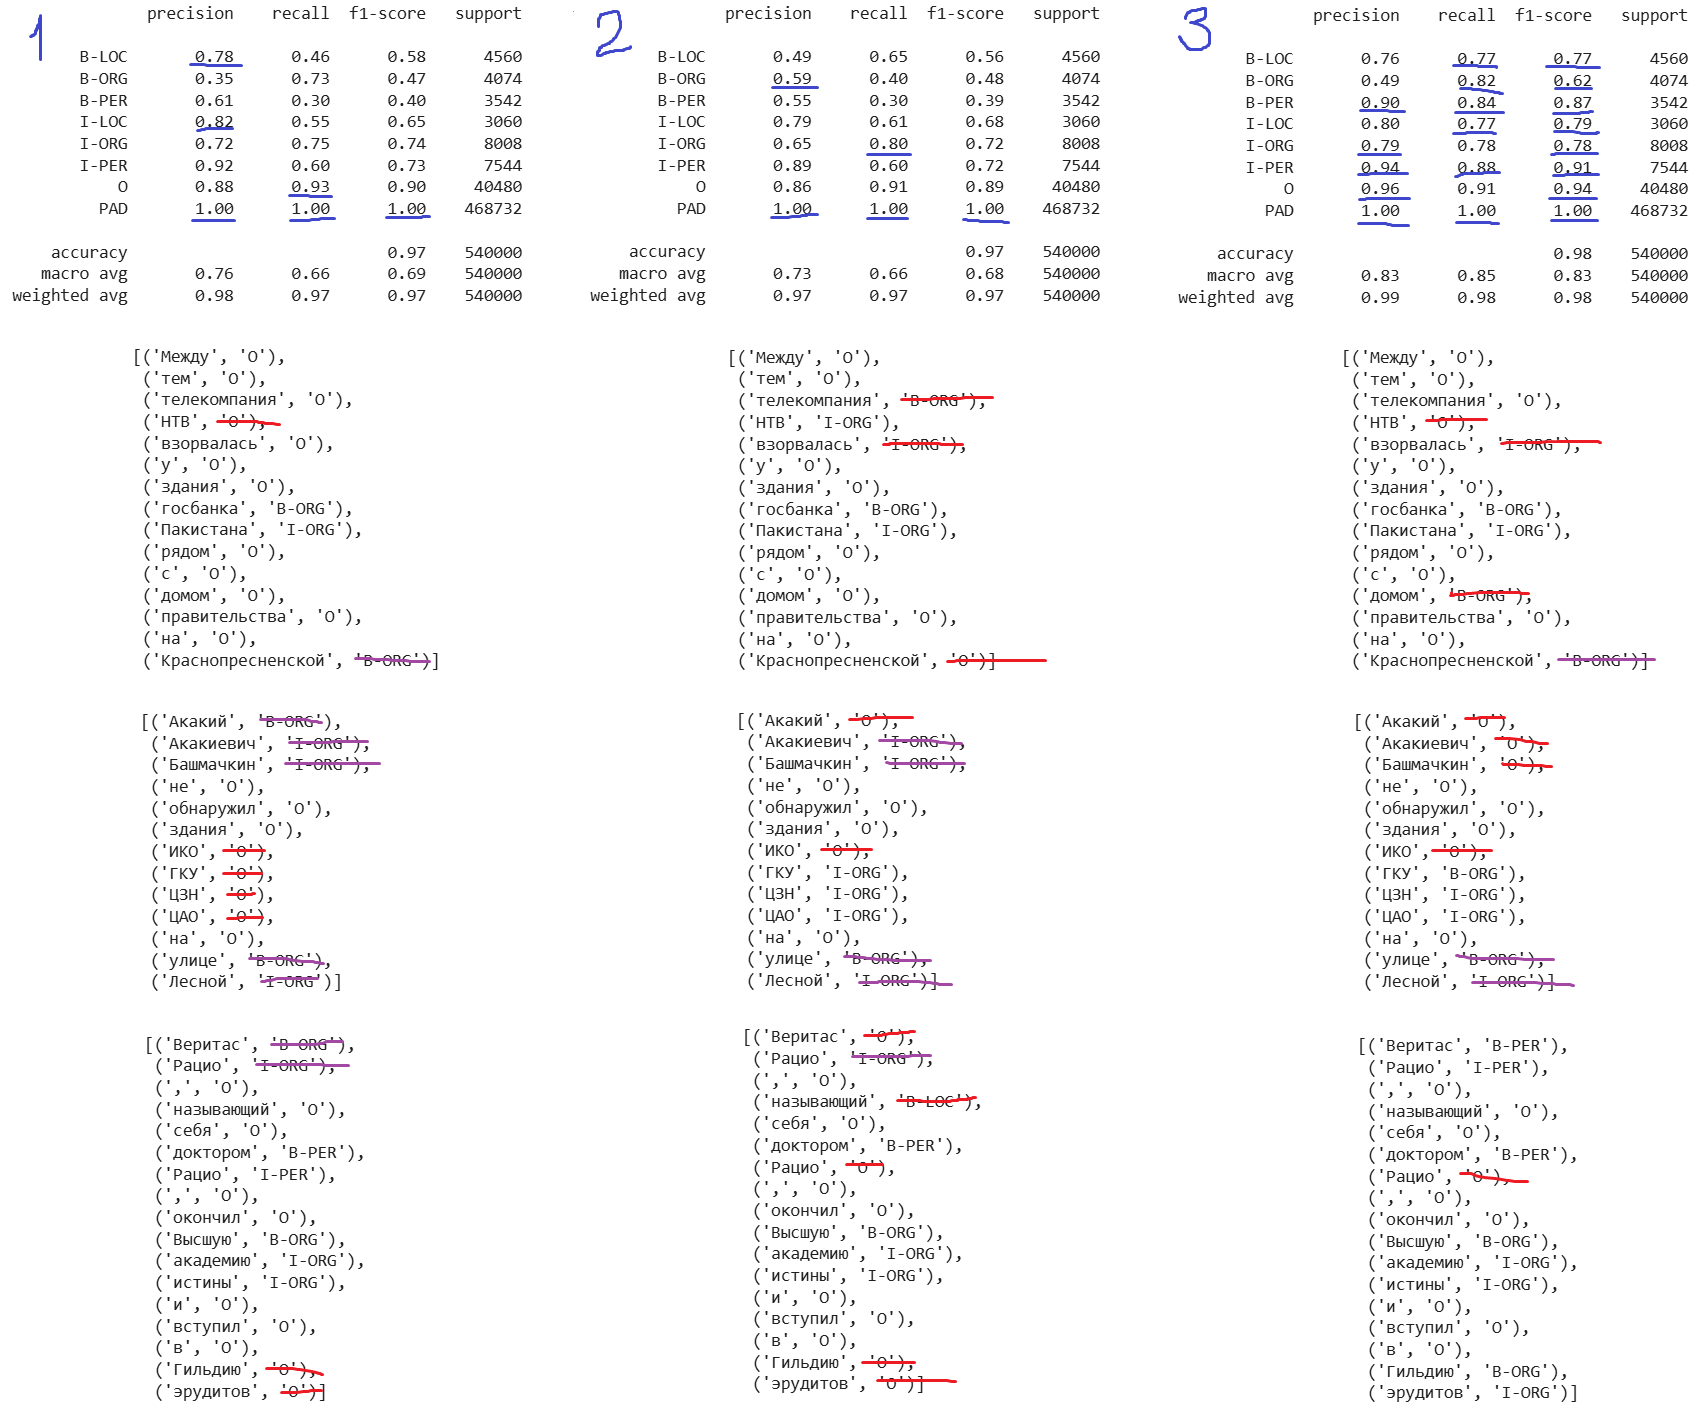